In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from simulation import Simulation
import os
os.environ["DDE_BACKEND"] = "pytorch" # Export Enviromental variable to use PyTorch
import deepxde as dde
from deepxde.backend import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


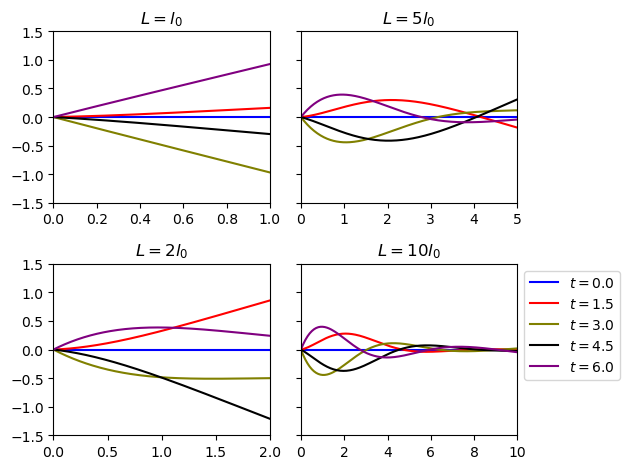

In [2]:
f, ax = plt.subplots(2, 2, sharey=True)
df1 = pd.read_parquet('./data/l1.parquet')
df2 = pd.read_parquet('./data/l2.parquet')
df5 = pd.read_parquet('./data/l5.parquet')
df10 = pd.read_parquet('./data/l10.parquet')
colors = ['blue', 'red', 'olive', 'black', 'purple']
for i in range(5):
    gap = 300000
    time = round(df1['t'][gap*i+1],1)
    ax[0, 0].plot(df1['x'][gap*i:gap*(i)+200], df1['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colors[i])
    ax[1, 0].plot(df2['x'][gap*i:gap*(i)+200], df2['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colors[i])
    ax[0, 1].plot(df5['x'][gap*i:gap*(i)+200], df5['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colors[i])
    ax[1, 1].plot(df10['x'][gap*i:gap*(i)+200], df10['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colors[i])
    ax[0, 0].set_ylim(-1.5, 1.5)
    ax[0, 0].set_xlim(0, 1)
    ax[1, 0].set_xlim(0, 2)
    ax[0, 1].set_xlim(0, 5)
    ax[1, 1].set_xlim(0, 10)
    ax[0, 0].set_title(r'$L = l_0$')
    ax[1, 0].set_title(r'$L = 2l_0$')
    ax[0, 1].set_title(r'$L = 5l_0$')
    ax[1, 1].set_title(r'$L = 10l_0$')
plt.legend(loc='lower right')
sns.move_legend(ax[1, 1], "upper left", bbox_to_anchor=(1, 1))
f.tight_layout()
plt.savefig('./figures/filaments.png', bbox_inches='tight')

In [3]:
def analytical_y(G, l0, L, f, x, t):
    c8 = np.cos(np.pi/8) # 0.92
    s8 = np.sin(np.pi/8) # 0.38
    theta = x*(c8 - 1j*s8)/l0
    phi = L*(c8 - 1j*s8)/l0
    p1 = G*l0*(np.exp(1j*(f*t + np.pi/8)))
    p2 = 1/(2 + 2*np.cosh(phi)*np.cos(phi))
    p3 = np.sin(theta) + np.sinh(theta) + np.sin(phi)*np.cosh(phi-theta) - np.cos(phi)*np.sinh(phi-theta) - np.cosh(phi)*np.sin(phi-theta) + np.sinh(phi)*np.cos(phi-theta)
    return p1*p2*p3

p = 12
ms = [2**x for x in range(4, p)]
time_errors = np.zeros(p-4)
length = 10*(1/4)**(1/4)
for k, m in enumerate(ms):
    sim = Simulation(timesteps=m,
                     n_points=2000,
                     max_time=10, osc_freq=4,
                     length=10*(1/4)**(1/4), eta=1)
    sim.run()
    y, x, t, _ = sim.get_data()
    dom = np.linspace(0, length, 2000)
    y_full = np.interp(dom, x, y[-1])
    analytical = analytical_y(G=1, l0=(1/4)**(1/4), L=10*(1/4)**(1/4), f=4, x=dom, t=t[-1])
    time_errors[k] = np.abs(np.real(y_full) - np.real(analytical)).sum()
    
p = 12
ns = [2**x for x in range(4, p)]
space_errors = np.zeros(p-4)
for k, n in enumerate(ns):
    sim = Simulation(timesteps=100000,
                     n_points=n,
                     max_time=10, osc_freq=4,
                     length=10*(1/4)**(1/4), eta=1)
    sim.run()
    y, x, t, _ = sim.get_data()
    dom = np.linspace(0, length, 200000)
    y_full = np.interp(dom, x, y[-1])
    analytical = analytical_y(G=1, l0=(1/4)**(1/4), L=10*(1/4)**(1/4), f=4, x=dom, t=t[-1])
    space_errors[k] = np.abs(np.real(y_full) - np.real(analytical)).sum()

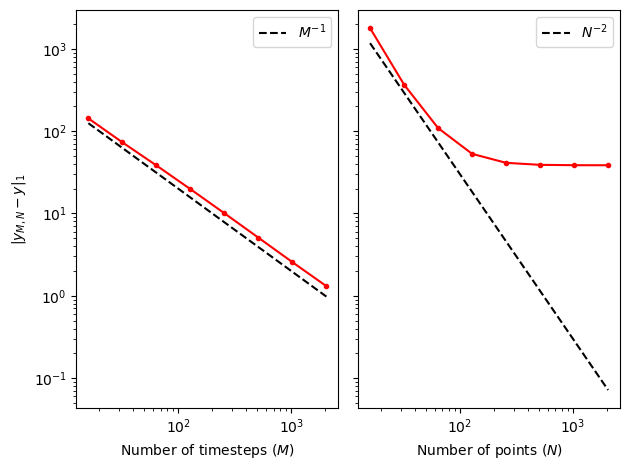

In [4]:
f, ax = plt.subplots(1, 2, sharey=True,)
ax[0].loglog(ms, time_errors, color='red', marker='.')
ax[0].loglog(ms, 2000*1/np.power(ms, 1), linestyle='--', color='black', label='$M^{-1}$')
ax[0].set_xlabel('Number of timesteps ($M$)')
ax[0].set_ylabel('$|y_{M,N} - y|_1$')
ax[0].legend()

ax[1].loglog(ns, space_errors, color='red', marker='.')
ax[1].loglog(ns, 300000*1/np.power(ns, 2), linestyle='--', color='black', label='$N^{-2}$')
ax[1].set_xlabel('Number of points ($N$)')
ax[1].legend()
f.tight_layout()
plt.savefig('./figures/all_errors.png', bbox_inches='tight')

In [5]:
loss = np.loadtxt('./eta_lhs_run2/loss.dat')
loss_df = pd.DataFrame(loss, columns=['step', 'train_pde', 'train_bc1', 'train_bc2', 'train_bc3', 'train_bc4',
                           'train_ic', 'test_pde', 'test_bc1', 'test_bc2', 'test_bc3', 'test_bc4',
                           'test_ic']) # [bc1, bc2, bc3, bc4, ic]
loss_df['train_loss'] = loss_df['train_pde'] +\
loss_df['train_bc1'] + loss_df['train_bc2'] + loss_df['train_bc3'] + loss_df['train_bc4'] + loss_df['train_ic']

In [6]:
geom = dde.geometry.Rectangle([0, 0.1], [1, 10000]) # X x [\eta]
timedomain = dde.geometry.TimeDomain(0, 1) # T
geomtime = dde.geometry.GeometryXTime(geom, timedomain) # X x [\eta] x T

def pde(x, y):
    """
    PDE residual definition
    x[:, 0:1] - x-variable
    x[:, 1:2] - eta
    x[:, 2:3] - t-variable
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return (
        x[:, 1:2]*dy_t
        + dy_xxxx
    )

def dy(x, y):
    dy_x = dde.grad.jacobian(y, x, j=0)
    return dy_x

def ddy(x, y):
    return dde.grad.hessian(y, x, i=0, j=0)

def dddy(x, y):
    dy_xx = dde.grad.jacobian(y, x, j=0)
    dy_xxx = dde.grad.hessian(dy_xx, x, j=0)
    return dy_xxx

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

bc1 = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_l)
bc2 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dy(x, y) - torch.cos(x[:, 2:3]), boundary_l)
bc3 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dddy(x, y), boundary_r)

ic = dde.icbc.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc1, bc2, bc3, bc4, ic],
    num_domain=6000,
    num_boundary=2000,
    num_initial=2000,
    num_test=6000,
)

def output_transform(x, y):
    return x[:, 0:1]*x[:, 2:3]*y
net = dde.nn.FNN([3] + [20] * 4 + [1], "tanh", "Glorot uniform")
#net.apply_output_transform(output_transform)
model = dde.Model(data, net)
model.compile("L-BFGS")
model.restore(save_path = "./eta_lhs_run/model-45000.pt")
ts = 1000
xs = 200
eta = 1

t_all = np.linspace(0, 1, ts)
x_all = np.linspace(0, 1, xs)
T, X = np.meshgrid(t_all, x_all, indexing='ij')
T_flat = T.ravel()
X_flat = X.ravel()
ETA_flat = np.full_like(T_flat, eta)

inputs = np.stack([X_flat, ETA_flat, T_flat], axis=-1)
sol_flat = model.predict(inputs)
sol = sol_flat.reshape(ts, xs)

data = pd.DataFrame(sol, columns=x_all, index=t_all)

x_val = data.columns.values
t_val = data.index.values
X, T = np.meshgrid(x_val, t_val)

Compiling model...
'compile' took 0.000070 s



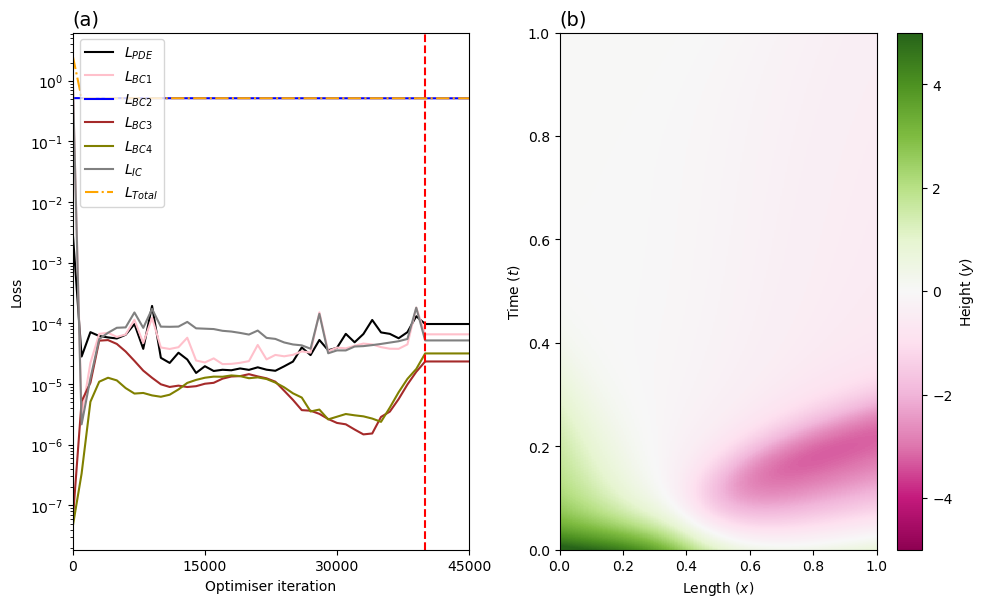

In [7]:
f, ax = plt.subplots(1, 2, figsize=(10, 6))
im = ax[1].pcolormesh(X, T, data.values, cmap='PiYG', vmin=-5, vmax=5)
ax[1].set_xlabel('Length ($x$)')
ax[1].set_ylabel('Time ($t$)')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].plot(loss_df['step'], loss_df['train_pde'], label='$L_{PDE}$', color='black')
ax[0].plot(loss_df['step'], loss_df['train_bc1'], label='$L_{BC1}$', color='pink')
ax[0].plot(loss_df['step'], loss_df['train_bc2'], label='$L_{BC2}$', color='blue')
ax[0].plot(loss_df['step'], loss_df['train_bc3'], label='$L_{BC3}$', color='brown')
ax[0].plot(loss_df['step'], loss_df['train_bc4'], label='$L_{BC4}$', color='olive')
ax[0].plot(loss_df['step'], loss_df['train_ic'], label='$L_{IC}$', color='gray')
ax[0].plot(loss_df['step'], loss_df['train_loss'], label='$L_{Total}$', ls='dashdot', color='orange')
ax[0].set_xlabel('Optimiser iteration')
ax[0].set_ylabel('Loss')
ax[0].axvline(40000, ls='dashed', color='red')
ax[0].set_xlim(0, 45000)
ax[0].set_xticks([0, 15000, 30000, 45000])
ax[0].set_yscale('log')
ax[0].legend(loc='upper left')
f.colorbar(im, label='Height ($y$)')
f.tight_layout()
ax[0].set_title('(a)', loc='left', fontsize=14,)
ax[1].set_title('(b)', loc='left', fontsize=14,)
plt.savefig('./figures/eta_lhs.png', bbox_inches='tight', dpi=200)